In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('training_dataset.csv', index_col='date', parse_dates=True)

In [3]:
df.head()

,eth_low,eth_high,eth_open,eth_close,eth_volume,month,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,...,stochastic_oscillator,ma_12,ma_26,ema_12,ema_26,obv,mfi,upper_band,middle_band,lower_band
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01,383.18,394.39,386.44,388.46,4198.68434,2017-09-01,1.635228e+06,4124.0,1564.05531,6.096309e+05,...,96.424850,346.524167,338.660000,346.524167,338.660000,1.378006e+06,88.346876,411.653941,341.8790,272.104059
2017-09-02,320.08,394.32,388.58,343.14,8240.32724,2017-09-01,2.904008e+06,8217.0,2460.66776,8.684873e+05,...,97.629707,348.178333,339.773462,348.178333,339.773462,1.369766e+06,80.426793,411.386517,341.6590,271.931483
2017-09-03,320.08,367.28,343.56,341.77,5253.62211,2017-09-01,1.801703e+06,6153.0,2240.91753,7.679383e+05,...,79.514749,350.842500,340.706923,350.842500,340.706923,1.364512e+06,74.419284,408.329187,340.1235,271.917813
2017-09-04,267.94,344.55,339.29,283.77,6737.81061,2017-09-01,2.002446e+06,7403.0,2954.16805,8.770111e+05,...,78.967144,348.178333,339.138077,348.178333,339.138077,1.357774e+06,67.246410,404.443029,335.1070,265.770971
2017-09-05,235.55,321.52,286.81,312.09,8344.41924,2017-09-01,2.397491e+06,8999.0,4312.97282,1.251959e+06,...,55.783836,347.234167,338.443846,347.234167,338.443846,1.366118e+06,66.412993,396.369992,331.2515,266.133008


In [4]:
df.index.freq = "D"

In [5]:
df.index

DatetimeIndex(['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09', '2017-09-10',
               ...
               '2023-02-26', '2023-02-27', '2023-02-28', '2023-03-01',
               '2023-03-02', '2023-03-03', '2023-03-04', '2023-03-05',
               '2023-03-06', '2023-03-07'],
              dtype='datetime64[ns]', name='date', length=2014, freq='D')

In [6]:
df_close = pd.DataFrame(df.eth_close)

<Axes: xlabel='date'>

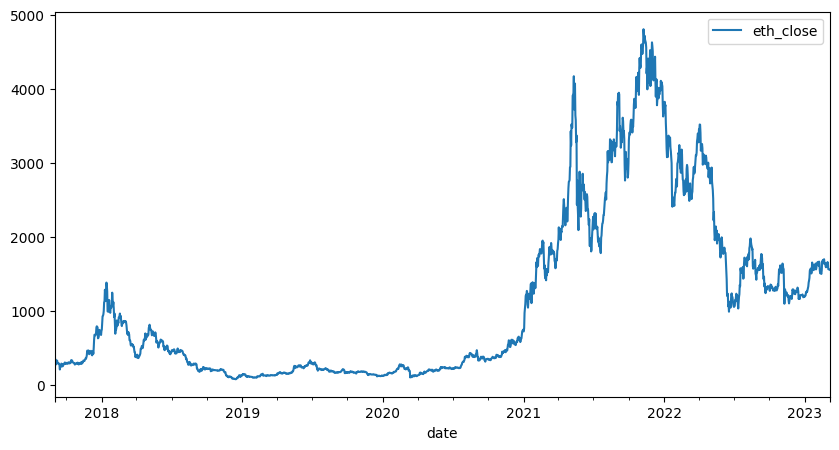

In [7]:
df_close.plot(figsize=(10,5))

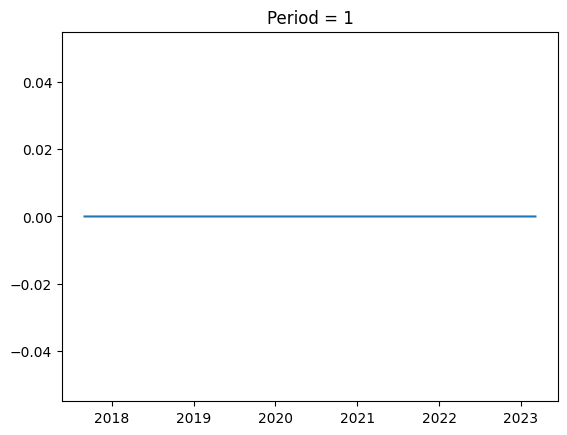

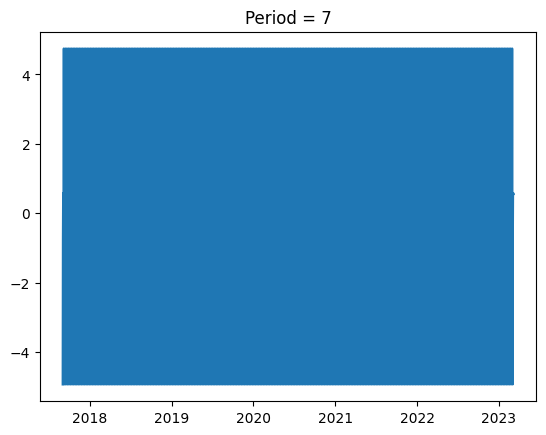

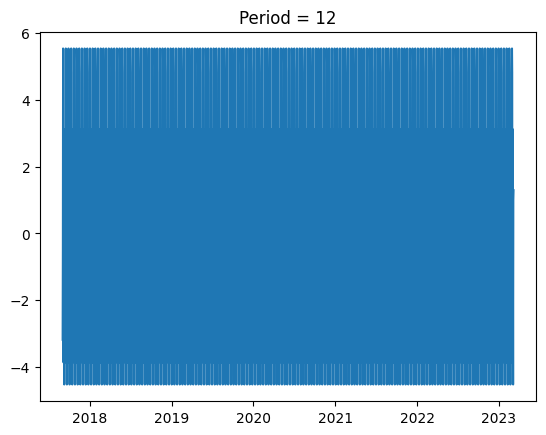

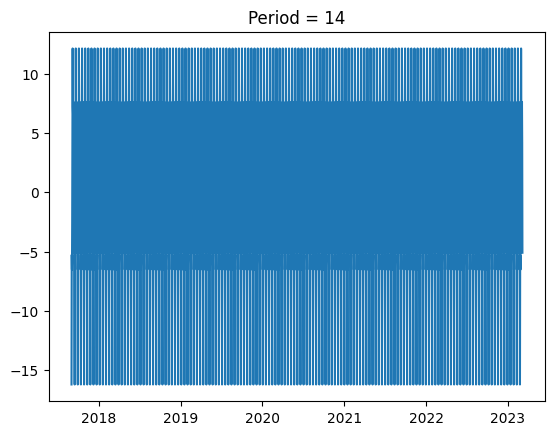

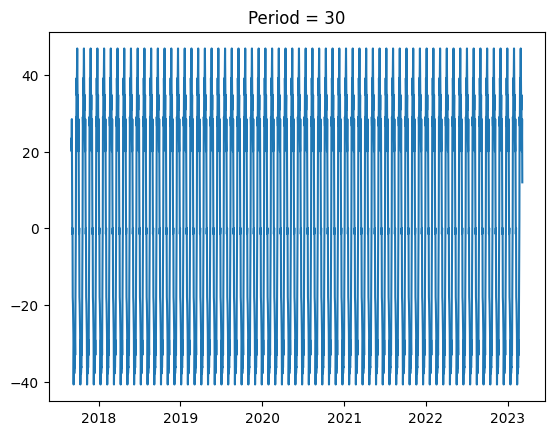

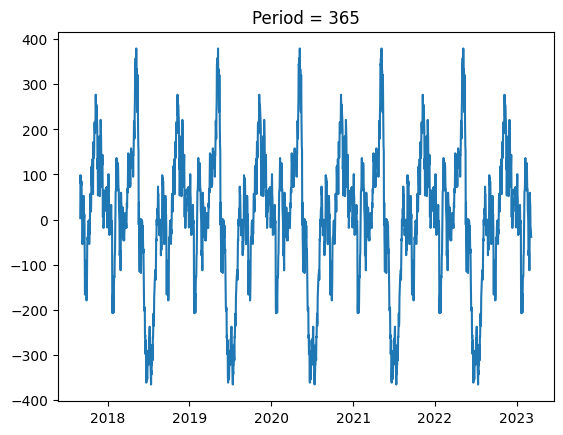

In [8]:
## Choose the appropriate period = 365
for period in [1,7,12,14,30,365]:
    result = seasonal_decompose(df.eth_close, period=period)
    plt.plot(result.seasonal)
    plt.title(f"Period = {period}")
    plt.show()
    

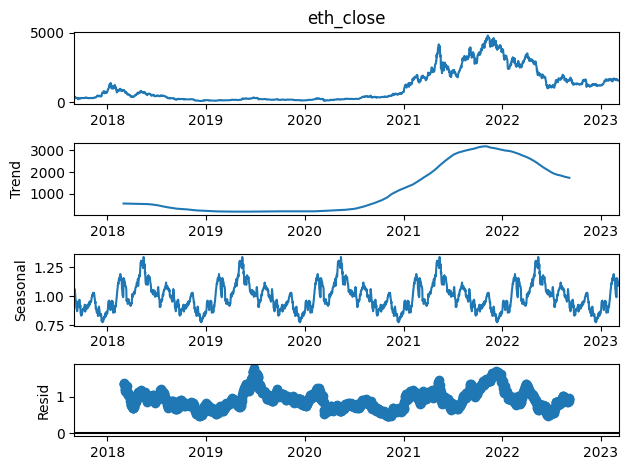

In [9]:
##Only 365 day period shows a possible seasonality
seasonality_trend = seasonal_decompose(df_close.eth_close, model="multiplicative", period=365)
seasonality_trend.plot()
plt.show()

In [10]:
df_close["logclose"] = np.log(df_close.eth_close)

<Axes: xlabel='date'>

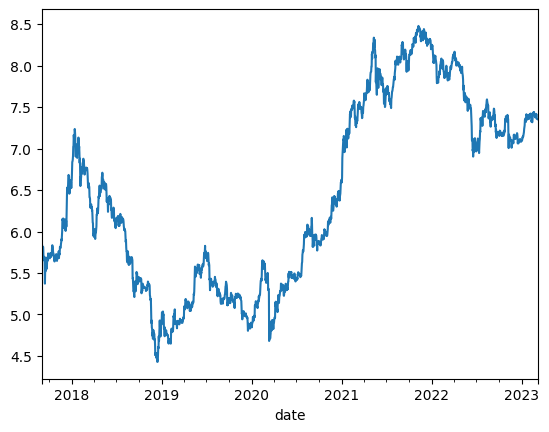

In [11]:
df_close["logclose"].plot()

In [12]:
df_close.shape

(2014, 2)

## Test on Validation set and best options

## Timeseries Split

## 1 DAY

In [13]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=1, gap=0)
df_close = df_close.sort_index()

In [21]:
def gridsearch_timeseriessplit(trend_type, seasonal_type, damped_trend, init_method):

    #fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    #fold = 0

    for train_idx, val_idx in tss.split(df_close):
        train = df_close.iloc[train_idx]
        test = df_close.iloc[val_idx]
        
        ## PLOTTING NOT IMPORTANT
        #train['eth_close'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
        #test['eth_close'].plot(ax=axs[fold], label='Test Set')
        #axs[fold].axvline(test.index.min(), color='black', ls='--')
        #fold += 1

        if seasonal_type != None:

            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type,
                  seasonal_periods=365)
        else:
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type)

        res_hw = hw.fit()
        fcast = res_hw.forecast(len(test))
        
        rmse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=False)
        root_mean_squared_errors.append(rmse)
        mse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=True)
        mean_squared_errors.append(mse)        
        mae = mean_absolute_error(test['eth_close'], np.exp(fcast))
        mean_absolute_errors.append(mae)
        mape = mean_absolute_percentage_error(test['eth_close'], np.exp(fcast))
        mean_absolute_percentage_errors.append(mape)
        

    #plt.show()

    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return np.mean(root_mean_squared_errors), np.mean(mean_squared_errors), np.mean(mean_absolute_errors), np.mean(mean_absolute_percentage_errors)

In [22]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul', None]
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
## box-cox not required since log dataset

In [23]:
# Grid Search
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list
)

In [24]:
best_rmse = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(*x)
    rmse, mse, mae, mape = gridsearch_timeseriessplit(*x)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = x

add add True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 20.7827
MSE: 1024.7884
MAE: 20.7827
MAPE: 1.3264%
RMSE: 20.78270388335168, MSE: 1024.7883548486814, MAE: 20.78270388335168, MAPE: 0.01326388140088161
Best RMSE so far: 20.78270388335168
add add True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 20.7827
MSE: 1024.7884
MAE: 20.7827
MAPE: 1.3264%
RMSE: 20.78270388335168, MSE: 1024.7883548486814, MAE: 20.78270388335168, MAPE: 0.01326388140088161
add add True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 22.4181
MSE: 1060.2748
MAE: 22.4181
MAPE: 1.431%
RMSE: 22.418113743701134, MSE: 1060.2747977818842, MAE: 22.418113743701134, MAPE: 0.01431011082777479
add add False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 20.7394
MSE: 952.7438
MAE: 20.7394
MAPE: 1.3237%
RMSE: 20.73938880719188, MSE: 952.7438055351271, MAE: 20.73938880719188, MAPE: 0.013237216947491554
Best RMSE so far: 20.73938880719188
add add False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 20.7394
MSE: 952.7438
MAE: 20.7394
MAPE: 1.3237%
RMSE: 20.73938880719188, MSE: 952.7438055351271, MAE: 20.73938880719188, MAPE: 0.013237216947491554
add add False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.7242
MSE: 987.704
MAE: 23.7242
MAPE: 1.5147%
RMSE: 23.72421817825825, MSE: 987.7040172344638, MAE: 23.72421817825825, MAPE: 0.015146578182220104
add mul True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.6415
MSE: 1129.0594
MAE: 23.6415
MAPE: 1.5087%
RMSE: 23.641477585274288, MSE: 1129.0593583185275, MAE: 23.641477585274288, MAPE: 0.015087153584225752
add mul True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.6415
MSE: 1129.0594
MAE: 23.6415
MAPE: 1.5087%
RMSE: 23.641477585274288, MSE: 1129.0593583185275, MAE: 23.641477585274288, MAPE: 0.015087153584225752
add mul True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 27.0649
MSE: 988.0237
MAE: 27.0649
MAPE: 1.7282%
RMSE: 27.06486551755579, MSE: 988.0236915031835, MAE: 27.06486551755579, MAPE: 0.01728171362125089
add mul False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.8509
MSE: 1104.7559
MAE: 23.8509
MAPE: 1.5222%
RMSE: 23.850896605107256, MSE: 1104.7559218071606, MAE: 23.850896605107256, MAPE: 0.015221836055049284
add mul False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.8509
MSE: 1104.7559
MAE: 23.8509
MAPE: 1.5222%
RMSE: 23.850896605107256, MSE: 1104.7559218071606, MAE: 23.850896605107256, MAPE: 0.015221836055049284
add mul False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.8446
MSE: 1200.0776
MAE: 23.8446
MAPE: 1.5213%
RMSE: 23.84455929707019, MSE: 1200.0775912992808, MAE: 23.84455929707019, MAPE: 0.015212981552975449
add None True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 18.9118
MSE: 1311.4001
MAE: 18.9118
MAPE: 1.2054%
RMSE: 18.911799663606054, MSE: 1311.4000841656136, MAE: 18.911799663606054, MAPE: 0.012054164036950909
Best RMSE so far: 18.911799663606054
add None True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 18.9118
MSE: 1311.4001
MAE: 18.9118
MAPE: 1.2054%
RMSE: 18.911799663606054, MSE: 1311.4000841656136, MAE: 18.911799663606054, MAPE: 0.012054164036950909
add None True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 18.9102
MSE: 1311.3179
MAE: 18.9102
MAPE: 1.2053%
RMSE: 18.91020904296274, MSE: 1311.317922852882, MAE: 18.

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.8953
MSE: 919.5692
MAE: 23.8953
MAPE: 1.5259%
RMSE: 23.895284481971792, MSE: 919.5691550729205, MAE: 23.895284481971792, MAPE: 0.01525932243885505
mul add True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.8953
MSE: 919.5692
MAE: 23.8953
MAPE: 1.5259%
RMSE: 23.895284481971792, MSE: 919.5691550729205, MAE: 23.895284481971792, MAPE: 0.01525932243885505
mul add True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 20.7397
MSE: 1017.4906
MAE: 20.7397
MAPE: 1.3237%
RMSE: 20.73974598052996, MSE: 1017.4905931308218, MAE: 20.73974598052996, MAPE: 0.013236815843530226
mul add False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 20.3528
MSE: 976.303
MAE: 20.3528
MAPE: 1.2989%
RMSE: 20.35280824746501, MSE: 976.3029858769698, MAE: 20.35280824746501, MAPE: 0.01298898787952445
mul add False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 20.3528
MSE: 976.303
MAE: 20.3528
MAPE: 1.2989%
RMSE: 20.35280824746501, MSE: 976.3029858769698, MAE: 20.35280824746501, MAPE: 0.01298898787952445
mul add False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 20.2564
MSE: 991.9934
MAE: 20.2564
MAPE: 1.2927%
RMSE: 20.25635637012224, MSE: 991.9934255705184, MAE: 20.25635637012224, MAPE: 0.012926898009636204
mul mul True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.7109
MSE: 1126.7952
MAE: 23.7109
MAPE: 1.5131%
RMSE: 23.71090022905323, MSE: 1126.79523930191, MAE: 23.71090022905323, MAPE: 0.015131456771110375
mul mul True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.7109
MSE: 1126.7952
MAE: 23.7109
MAPE: 1.5131%
RMSE: 23.71090022905323, MSE: 1126.79523930191, MAE: 23.71090022905323, MAPE: 0.015131456771110375
mul mul True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 34.5409
MSE: 1451.1456
MAE: 34.5409
MAPE: 2.2063%
RMSE: 34.5408932646777, MSE: 1451.1455586088846, MAE: 34.5408932646777, MAPE: 0.022063251759325105
mul mul False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.4807
MSE: 1119.2739
MAE: 23.4807
MAPE: 1.4984%
RMSE: 23.48070941282931, MSE: 1119.2739051424098, MAE: 23.48070941282931, MAPE: 0.014983955558357734
mul mul False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 23.4807
MSE: 1119.2739
MAE: 23.4807
MAPE: 1.4984%
RMSE: 23.48070941282931, MSE: 1119.2739051424098, MAE: 23.48070941282931, MAPE: 0.014983955558357734
mul mul False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\P

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 21.7816
MSE: 972.4351
MAE: 21.7816
MAPE: 1.3901%
RMSE: 21.781638638843106, MSE: 972.4351263181346, MAE: 21.781638638843106, MAPE: 0.013900652596956959
mul None True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 18.9141
MSE: 1313.9295
MAE: 18.9141
MAPE: 1.2056%
RMSE: 18.914066997745522, MSE: 1313.9294551991297, MAE: 18.914066997745522, MAPE: 0.012055551412565419
mul None True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 18.9141
MSE: 1313.9295
MAE: 18.9141
MAPE: 1.2056%
RMSE: 18.914066997745522, MSE: 1313.9294551991297, MAE: 18.914066997745522, MAPE: 0.012055551412565419
mul None True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 18.9148
MSE: 1313.9547
MAE: 18.9148
MAPE: 1.2056%
RMSE: 18.914753967683417, MSE: 1313.954688905876, MAE: 18.914753967683417, MAPE: 0.01205598998

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Tesztelve 5 különböző tanulási/tesztelési adatszetten - 1 napos predikció
RMSE: 19.4603
MSE: 1312.7369
MAE: 19.4603
MAPE: 1.2406%
RMSE: 19.460336621017404, MSE: 1312.7369423380378, MAE: 19.460336621017404, MAPE: 0.012405723958825684


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [25]:
print("Legjobb RMSE:", round(best_rmse, 4))
print("Legjobb MSE:", round(best_rmse, 4))
print("Legjobb MAE:", round(best_mae, 4))
print("Legjobb MAPE:", round(best_mape*100, 4))


trend_type, seasonal_type, damped_trend, init_method = best_options
print("Legjobb hiperparaméter-kombináció")
print("trend_type:", trend_type)
print("seasonal_type:", seasonal_type)
print("damped_trend:", damped_trend)
print("init_method:", init_method)

Legjobb RMSE: 18.9102
Legjobb MSE: 18.9102
Legjobb MAE: 18.9102
Legjobb MAPE: 1.2053
Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: None
damped_trend: True
init_method: legacy-heuristic


## Findings

- Legjobb RMSE: 18.9102
- Legjobb MSE: 18.9102
- Legjobb MAE: 18.9102
- Legjobb MAPE: 1.2053

Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: None
damped_trend: True
init_method: legacy-heuristic

## 3 DAY

In [26]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=3, gap=0)
df_close = df_close.sort_index()

In [27]:
def gridsearch_timeseriessplit(trend_type, seasonal_type, damped_trend, init_method):

    #fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    #fold = 0

    for train_idx, val_idx in tss.split(df_close):
        train = df_close.iloc[train_idx]
        test = df_close.iloc[val_idx]
        
        ## PLOTTING NOT IMPORTANT
        #train['eth_close'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
        #test['eth_close'].plot(ax=axs[fold], label='Test Set')
        #axs[fold].axvline(test.index.min(), color='black', ls='--')
        #fold += 1

        if seasonal_type != None:

            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type,
                  seasonal_periods=365)
        else:
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type)

        res_hw = hw.fit()
        fcast = res_hw.forecast(len(test))
        
        rmse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=False)
        root_mean_squared_errors.append(rmse)
        mse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=True)
        mean_squared_errors.append(mse)        
        mae = mean_absolute_error(test['eth_close'], np.exp(fcast))
        mean_absolute_errors.append(mae)
        mape = mean_absolute_percentage_error(test['eth_close'], np.exp(fcast))
        mean_absolute_percentage_errors.append(mape)
        

    #plt.show()

    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return np.mean(root_mean_squared_errors), np.mean(mean_squared_errors), np.mean(mean_absolute_errors), np.mean(mean_absolute_percentage_errors)

In [28]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul', None]
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
## box-cox not required since log dataset

In [29]:
# Grid Search
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list
)

In [30]:
best_rmse = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(*x)
    rmse, mse, mae, mape = gridsearch_timeseriessplit(*x)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = x

add add True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.6316
MSE: 1623.4944
MAE: 31.7688
MAPE: 1.9758%
RMSE: 36.63155111088825, MSE: 1623.494371265107, MAE: 31.76881332649608, MAPE: 0.0197584954568418
Best RMSE so far: 36.63155111088825
add add True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.6316
MSE: 1623.4944
MAE: 31.7688
MAPE: 1.9758%
RMSE: 36.63155111088825, MSE: 1623.494371265107, MAE: 31.76881332649608, MAPE: 0.0197584954568418
add add True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 37.6098
MSE: 1637.1478
MAE: 32.8304
MAPE: 2.0438%
RMSE: 37.609811348346625, MSE: 1637.1477731334774, MAE: 32.830365221935764, MAPE: 0.020437789933063617
add add False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 35.6604
MSE: 1510.8259
MAE: 31.2581
MAPE: 1.9405%
RMSE: 35.66038567124734, MSE: 1510.8258638555953, MAE: 31.25809762797177, MAPE: 0.019404789908628532
Best RMSE so far: 35.66038567124734
add add False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 35.6604
MSE: 1510.8259
MAE: 31.2581
MAPE: 1.9405%
RMSE: 35.66038567124734, MSE: 1510.8258638555953, MAE: 31.25809762797177, MAPE: 0.019404789908628532
add add False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 37.7158
MSE: 1573.9589
MAE: 32.6839
MAPE: 2.0293%
RMSE: 37.71582467858086, MSE: 1573.9589433663057, MAE: 32.68392779053123, MAPE: 0.020292837080300875
add mul True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.5152
MSE: 1524.4455
MAE: 32.1718
MAPE: 1.9975%
RMSE: 36.515219997305785, MSE: 1524.4455440324182, MAE: 32.17177417454785, MAPE: 0.019974522914983767
add mul True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.5152
MSE: 1524.4455
MAE: 32.1718
MAPE: 1.9975%
RMSE: 36.515219997305785, MSE: 1524.4455440324182, MAE: 32.17177417454785, MAPE: 0.019974522914983767
add mul True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 35.5435
MSE: 1385.6469
MAE: 30.8981
MAPE: 1.9202%
RMSE: 35.54350962777765, MSE: 1385.646866006861, MAE: 30.898073846125772, MAPE: 0.01920210442721504
Best RMSE so far: 35.54350962777765
add mul False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 35.9451
MSE: 1470.6666
MAE: 31.4807
MAPE: 1.9543%
RMSE: 35.94510252423877, MSE: 1470.6666202847828, MAE: 31.480680370287455, MAPE: 0.01954282669194504
add mul False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 35.9451
MSE: 1470.6666
MAE: 31.4807
MAPE: 1.9543%
RMSE: 35.94510252423877, MSE: 1470.6666202847828, MAE: 31.480680370287455, MAPE: 0.01954282669194504
add mul False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 38.1457
MSE: 1782.7986
MAE: 33.4655
MAPE: 2.0753%
RMSE: 38.14569642120145, MSE: 1782.7985744406546, MAE: 33.46547259940089, MAPE: 0.020753360302475383
add None True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 39.7393
MSE: 2242.0411
MAE: 35.7234
MAPE: 2.2205%
RMSE: 39.739301640597944, MSE: 2242.041135631181, MAE: 35.72341517833118, MAPE: 0.022205103911274972
add None True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 39.7393
MSE: 2242.0411
MAE: 35.7234
MAPE: 2.2205%
RMSE: 39.739301640597944, MSE: 2242.041135631181, MAE: 35.72341517833118, MAPE: 0.022205103911274972
add None True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 39.7395
MSE: 2242.1345
MAE: 35.7242
MAPE: 2.2206%
RMSE: 39.73945061259674, MSE: 2242.1344556550034, MAE: 35.72423417928631, MAPE: 0.0222056207056201

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 38.4499
MSE: 1641.7159
MAE: 32.6917
MAPE: 2.0313%
RMSE: 38.44990115497568, MSE: 1641.7158538068666, MAE: 32.691675005912735, MAPE: 0.020312948223747608
mul add True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 38.4499
MSE: 1641.7159
MAE: 32.6917
MAPE: 2.0313%
RMSE: 38.44990115497568, MSE: 1641.7158538068666, MAE: 32.691675005912735, MAPE: 0.020312948223747608
mul add True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 37.7604
MSE: 1741.4358
MAE: 32.8184
MAPE: 2.0416%
RMSE: 37.76039243697481, MSE: 1741.4358037670268, MAE: 32.8183655831587, MAPE: 0.020416082799987
mul add False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 35.7268
MSE: 1570.8094
MAE: 31.4374
MAPE: 1.953%
RMSE: 35.72680921921796, MSE: 1570.8094124254085, MAE: 31.437426658588628, MAPE: 0.01952979845968426
mul add False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 35.7268
MSE: 1570.8094
MAE: 31.4374
MAPE: 1.953%
RMSE: 35.72680921921796, MSE: 1570.8094124254085, MAE: 31.437426658588628, MAPE: 0.01952979845968426
mul add False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.7401
MSE: 1664.5465
MAE: 32.0096
MAPE: 1.9906%
RMSE: 36.74009644585807, MSE: 1664.5464681792032, MAE: 32.00958101446434, MAPE: 0.01990620815944019
mul mul True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.5931
MSE: 1531.8302
MAE: 32.246
MAPE: 2.0022%
RMSE: 36.59314546083277, MSE: 1531.8302170318584, MAE: 32.24603090514744, MAPE: 0.02002196263566957
mul mul True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.5931
MSE: 1531.8302
MAE: 32.246
MAPE: 2.0022%
RMSE: 36.59314546083277, MSE: 1531.8302170318584, MAE: 32.24603090514744, MAPE: 0.02002196263566957
mul mul True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 39.35
MSE: 1800.3961
MAE: 33.028
MAPE: 2.0543%
RMSE: 39.34999630798693, MSE: 1800.3960884999155, MAE: 33.027955336283036, MAPE: 0.02054285640291849
mul mul False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.4886
MSE: 1545.2078
MAE: 32.2336
MAPE: 2.0005%
RMSE: 36.488642951824, MSE: 1545.2077665873985, MAE: 32.23355872561921, MAPE: 0.02000526187886599
mul mul False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.4886
MSE: 1545.2078
MAE: 32.2336
MAPE: 2.0005%
RMSE: 36.488642951824, MSE: 1545.2077665873985, MAE: 32.23355872561921, MAPE: 0.02000526187886599
mul mul False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 36.5123
MSE: 1516.0008
MAE: 32.0155
MAPE: 1.9849%
RMSE: 36.5123366579746, MSE: 1516.0008492877464, MAE: 32.015540237153104, MAPE: 0.01984876072162741
mul None True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 39.8306
MSE: 2250.0728
MAE: 35.7989
MAPE: 2.2252%
RMSE: 39.830603060524254, MSE: 2250.072754353441, MAE: 35.79890197638581, MAPE: 0.02225195148470389
mul None True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 39.8306
MSE: 2250.0728
MAE: 35.7989
MAPE: 2.2252%
RMSE: 39.830603060524254, MSE: 2250.072754353441, MAE: 35.79890197638581, MAPE: 0.02225195148470389
mul None True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 39.8304
MSE: 2250.0839
MAE: 35.7987
MAPE: 2.2252%
RMSE: 39.83044008172938, MSE: 2250.08387269124, MAE: 35.798676406226136, MAPE: 0.022251812896346805
m

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Tesztelve 5 különböző tanulási/tesztelési adatszetten - 3 napos predikció
RMSE: 41.0383
MSE: 2311.1403
MAE: 37.3243
MAPE: 2.3224%
RMSE: 41.03825260716842, MSE: 2311.1402968271186, MAE: 37.32432658605782, MAPE: 0.02322428729828195


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [31]:
print("Legjobb RMSE:", round(best_rmse, 4))
print("Legjobb MSE:", round(best_rmse, 4))
print("Legjobb MAE:", round(best_mae, 4))
print("Legjobb MAPE:", round(best_mape*100, 4))


trend_type, seasonal_type, damped_trend, init_method = best_options
print("Legjobb hiperparaméter-kombináció")
print("trend_type:", trend_type)
print("seasonal_type:", seasonal_type)
print("damped_trend:", damped_trend)
print("init_method:", init_method)

Legjobb RMSE: 35.5435
Legjobb MSE: 35.5435
Legjobb MAE: 30.8981
Legjobb MAPE: 1.9202
Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: mul
damped_trend: True
init_method: legacy-heuristic


## Findings

Legjobb RMSE: 35.5435
Legjobb MSE: 35.5435
Legjobb MAE: 30.8981
Legjobb MAPE: 1.9202

Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: mul
damped_trend: True
init_method: legacy-heuristic

## 7 DAY

In [32]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=7, gap=0)
df_close = df_close.sort_index()

In [33]:
def gridsearch_timeseriessplit(trend_type, seasonal_type, damped_trend, init_method):

    #fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    #fold = 0

    for train_idx, val_idx in tss.split(df_close):
        train = df_close.iloc[train_idx]
        test = df_close.iloc[val_idx]
        
        ## PLOTTING NOT IMPORTANT
        #train['eth_close'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
        #test['eth_close'].plot(ax=axs[fold], label='Test Set')
        #axs[fold].axvline(test.index.min(), color='black', ls='--')
        #fold += 1

        if seasonal_type != None:

            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type,
                  seasonal_periods=365)
        else:
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type)

        res_hw = hw.fit()
        fcast = res_hw.forecast(len(test))
        
        rmse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=False)
        root_mean_squared_errors.append(rmse)
        mse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=True)
        mean_squared_errors.append(mse)        
        mae = mean_absolute_error(test['eth_close'], np.exp(fcast))
        mean_absolute_errors.append(mae)
        mape = mean_absolute_percentage_error(test['eth_close'], np.exp(fcast))
        mean_absolute_percentage_errors.append(mape)
        

    #plt.show()

    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return np.mean(root_mean_squared_errors), np.mean(mean_squared_errors), np.mean(mean_absolute_errors), np.mean(mean_absolute_percentage_errors)

In [34]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul', None]
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
## box-cox not required since log dataset

In [35]:
# Grid Search
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list
)

In [36]:
best_rmse = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(*x)
    rmse, mse, mae, mape = gridsearch_timeseriessplit(*x)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = x

add add True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 98.8744
MSE: 14621.3
MAE: 93.1133
MAPE: 5.8482%
RMSE: 98.87438434514972, MSE: 14621.300004798308, MAE: 93.11330661996976, MAPE: 0.05848170542464365
Best RMSE so far: 98.87438434514972
add add True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 98.8744
MSE: 14621.3
MAE: 93.1133
MAPE: 5.8482%
RMSE: 98.87438434514972, MSE: 14621.300004798308, MAE: 93.11330661996976, MAPE: 0.05848170542464365
add add True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 102.7338
MSE: 17140.9381
MAE: 96.9654
MAPE: 6.1065%
RMSE: 102.73379307032364, MSE: 17140.93811397496, MAE: 96.96535306546512, MAPE: 0.06106509139938223
add add False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 99.5111
MSE: 15137.6063
MAE: 93.6477
MAPE: 5.8836%
RMSE: 99.51111831529411, MSE: 15137.606319250039, MAE: 93.64771346911839, MAPE: 0.058836205846841946
add add False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 99.5111
MSE: 15137.6063
MAE: 93.6477
MAPE: 5.8836%
RMSE: 99.51111831529411, MSE: 15137.606319250039, MAE: 93.64771346911839, MAPE: 0.058836205846841946
add add False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 105.1768
MSE: 15804.2705
MAE: 98.3994
MAPE: 6.1559%
RMSE: 105.17678646671159, MSE: 15804.270497345944, MAE: 98.3994174010338, MAPE: 0.06155896993657538
add mul True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 104.8125
MSE: 16958.9369
MAE: 98.7577
MAPE: 6.2058%
RMSE: 104.8125406985431, MSE: 16958.936897870128, MAE: 98.75768960613587, MAPE: 0.06205790109115661
add mul True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 104.8125
MSE: 16958.9369
MAE: 98.7577
MAPE: 6.2058%
RMSE: 104.8125406985431, MSE: 16958.936897870128, MAE: 98.75768960613587, MAPE: 0.06205790109115661
add mul True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 115.9524
MSE: 21546.4883
MAE: 110.0027
MAPE: 6.9043%
RMSE: 115.95239322589046, MSE: 21546.488320422715, MAE: 110.00267932317941, MAPE: 0.06904306942198217
add mul False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 102.5606
MSE: 16008.7373
MAE: 96.5256
MAPE: 6.0609%
RMSE: 102.56063685857877, MSE: 16008.737298342836, MAE: 96.52562090838077, MAPE: 0.060609255792844374
add mul False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 102.5606
MSE: 16008.7373
MAE: 96.5256
MAPE: 6.0609%
RMSE: 102.56063685857877, MSE: 16008.737298342836, MAE: 96.52562090838077, MAPE: 0.060609255792844374
add mul False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 107.2428
MSE: 14518.6772
MAE: 99.3831
MAPE: 6.2054%
RMSE: 107.24284047834001, MSE: 14518.677194533788, MAE: 99.3830975521432, MAPE: 0.062054499151741695
add None True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 83.1631
MSE: 8487.7853
MAE: 79.4005
MAPE: 4.9301%
RMSE: 83.16312327712959, MSE: 8487.785287924375, MAE: 79.40054318280768, MAPE: 0.04930054688797668
Best RMSE so far: 83.16312327712959
add None True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 83.1631
MSE: 8487.7853
MAE: 79.4005
MAPE: 4.9301%
RMSE: 83.16312327712959, MSE: 8487.785287924375, MAE: 79.40054318280768, MAPE: 0.04930054688797668
add None True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 83.1608
MSE: 8487.433
MAE: 79.3981
MAPE: 4.9299%
RMSE: 83.16080481667561, MSE: 8487.433023116997, MAE: 79.39811918

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 106.1093
MSE: 15436.2877
MAE: 99.6919
MAPE: 6.2098%
RMSE: 106.10925938677683, MSE: 15436.287697723863, MAE: 99.69190929682503, MAPE: 0.06209789048477945
mul add True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 106.1093
MSE: 15436.2877
MAE: 99.6919
MAPE: 6.2098%
RMSE: 106.10925938677683, MSE: 15436.287697723863, MAE: 99.69190929682503, MAPE: 0.06209789048477945
mul add True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 106.6753
MSE: 19455.8982
MAE: 97.796
MAPE: 6.1909%
RMSE: 106.67529768876327, MSE: 19455.898247117126, MAE: 97.79600849602608, MAPE: 0.061908739832265317
mul add False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 98.477
MSE: 15366.3871
MAE: 93.0826
MAPE: 5.8612%
RMSE: 98.47700394255278, MSE: 15366.387147327052, MAE: 93.08262612769458, MAPE: 0.05861153233176099
mul add False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 98.477
MSE: 15366.3871
MAE: 93.0826
MAPE: 5.8612%
RMSE: 98.47700394255278, MSE: 15366.387147327052, MAE: 93.08262612769458, MAPE: 0.05861153233176099
mul add False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 97.5596
MSE: 15587.6799
MAE: 92.3419
MAPE: 5.8234%
RMSE: 97.55960553705063, MSE: 15587.679939313664, MAE: 92.34190041859291, MAPE: 0.05823401579879896
mul mul True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 105.2037
MSE: 17059.1391
MAE: 99.1378
MAPE: 6.2299%
RMSE: 105.20372563665987, MSE: 17059.139078711476, MAE: 99.13782066559156, MAPE: 0.06229895840139984
mul mul True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 105.2037
MSE: 17059.1391
MAE: 99.1378
MAPE: 6.2299%
RMSE: 105.20372563665987, MSE: 17059.139078711476, MAE: 99.13782066559156, MAPE: 0.06229895840139984
mul mul True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 124.2549
MSE: 23895.8225
MAE: 116.0086
MAPE: 7.311%
RMSE: 124.25493129559668, MSE: 23895.822467013695, MAE: 116.0086306860733, MAPE: 0.07311027486309053
mul mul False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 101.5359
MSE: 16262.9459
MAE: 95.6594
MAPE: 6.0218%
RMSE: 101.53594344849667, MSE: 16262.945880150724, MAE: 95.65938084339338, MAPE: 0.06021801320593566
mul mul False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 101.5359
MSE: 16262.9459
MAE: 95.6594
MAPE: 6.0218%
RMSE: 101.53594344849667, MSE: 16262.945880150724, MAE: 95.65938084339338, MAPE: 0.06021801320593566
mul mul False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python3

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 100.4234
MSE: 13981.2868
MAE: 93.5144
MAPE: 5.8425%
RMSE: 100.4234123357697, MSE: 13981.286786738556, MAE: 93.51438607078681, MAPE: 0.058425035117760246
mul None True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 83.2196
MSE: 8499.7803
MAE: 79.456
MAPE: 4.9336%
RMSE: 83.21955752257239, MSE: 8499.780266290543, MAE: 79.45603219132747, MAPE: 0.04933552789906408
mul None True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 83.2196
MSE: 8499.7803
MAE: 79.456
MAPE: 4.9336%
RMSE: 83.21955752257239, MSE: 8499.780266290543, MAE: 79.45603219132747, MAPE: 0.04933552789906408
mul None True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 83.2193
MSE: 8499.6732
MAE: 79.4559
MAPE: 4.9335%
RMSE: 83.21934054389749, MSE: 8499.673231742596, MAE: 79.45587710028632, MAPE: 0.04933537879548527
mul

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Tesztelve 5 különböző tanulási/tesztelési adatszetten - 7 napos predikció
RMSE: 82.5436
MSE: 8267.0596
MAE: 78.7337
MAPE: 4.8968%
RMSE: 82.54359083454668, MSE: 8267.059601843768, MAE: 78.73369968790958, MAPE: 0.04896804049546179


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [37]:
print("Legjobb RMSE:", round(best_rmse, 4))
print("Legjobb MSE:", round(best_rmse, 4))
print("Legjobb MAE:", round(best_mae, 4))
print("Legjobb MAPE:", round(best_mape*100, 4))


trend_type, seasonal_type, damped_trend, init_method = best_options
print("Legjobb hiperparaméter-kombináció")
print("trend_type:", trend_type)
print("seasonal_type:", seasonal_type)
print("damped_trend:", damped_trend)
print("init_method:", init_method)

Legjobb RMSE: 82.5173
Legjobb MSE: 82.5173
Legjobb MAE: 78.7072
Legjobb MAPE: 4.8951
Legjobb hiperparaméter-kombináció
trend_type: mul
seasonal_type: None
damped_trend: False
init_method: estimated


## Findings

- Legjobb RMSE: 82.5173
- Legjobb MSE: 82.5173
- Legjobb MAE: 78.7072
- Legjobb MAPE: 4.8951

Legjobb hiperparaméter-kombináció
trend_type: mul
seasonal_type: None
damped_trend: False
init_method: estimated

## 14 DAY

In [38]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=14, gap=0)
df_close = df_close.sort_index()

In [39]:
def gridsearch_timeseriessplit(trend_type, seasonal_type, damped_trend, init_method):

    #fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    #fold = 0

    for train_idx, val_idx in tss.split(df_close):
        train = df_close.iloc[train_idx]
        test = df_close.iloc[val_idx]
        
        ## PLOTTING NOT IMPORTANT
        #train['eth_close'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
        #test['eth_close'].plot(ax=axs[fold], label='Test Set')
        #axs[fold].axvline(test.index.min(), color='black', ls='--')
        #fold += 1

        if seasonal_type != None:

            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type,
                  seasonal_periods=365)
        else:
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type)

        res_hw = hw.fit()
        fcast = res_hw.forecast(len(test))
        
        rmse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=False)
        root_mean_squared_errors.append(rmse)
        mse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=True)
        mean_squared_errors.append(mse)        
        mae = mean_absolute_error(test['eth_close'], np.exp(fcast))
        mean_absolute_errors.append(mae)
        mape = mean_absolute_percentage_error(test['eth_close'], np.exp(fcast))
        mean_absolute_percentage_errors.append(mape)
        

    #plt.show()

    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return np.mean(root_mean_squared_errors), np.mean(mean_squared_errors), np.mean(mean_absolute_errors), np.mean(mean_absolute_percentage_errors)

In [40]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul', None]
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
## box-cox not required since log dataset

In [41]:
# Grid Search
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list
)

In [42]:
best_rmse = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(*x)
    rmse, mse, mae, mape = gridsearch_timeseriessplit(*x)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = x

add add True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 134.0456
MSE: 23893.6663
MAE: 119.9424
MAPE: 7.8838%
RMSE: 134.04561790932223, MSE: 23893.666269838795, MAE: 119.9424432414911, MAPE: 0.07883834233087841
Best RMSE so far: 134.04561790932223
add add True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 134.0456
MSE: 23893.6663
MAE: 119.9424
MAPE: 7.8838%
RMSE: 134.04561790932223, MSE: 23893.666269838795, MAE: 119.9424432414911, MAPE: 0.07883834233087841
add add True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 145.5758
MSE: 26849.5295
MAE: 129.4702
MAPE: 8.4937%
RMSE: 145.57576339019005, MSE: 26849.529534305562, MAE: 129.47020943720298, MAPE: 0.08493664337864872
add add False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 142.5745
MSE: 26942.8421
MAE: 128.4017
MAPE: 8.4048%
RMSE: 142.57447764109318, MSE: 26942.842125372, MAE: 128.40168610490682, MAPE: 0.08404788424220268
add add False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 142.5745
MSE: 26942.8421
MAE: 128.4017
MAPE: 8.4048%
RMSE: 142.57447764109318, MSE: 26942.842125372, MAE: 128.40168610490682, MAPE: 0.08404788424220268
add add False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 145.2013
MSE: 28418.81
MAE: 129.4581
MAPE: 8.3967%
RMSE: 145.20128062824065, MSE: 28418.80998972138, MAE: 129.4581189271516, MAPE: 0.08396681176891499
add mul True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 150.247
MSE: 30542.0079
MAE: 134.3539
MAPE: 8.8168%
RMSE: 150.24704917967145, MSE: 30542.007918016643, MAE: 134.35391717902675, MAPE: 0.08816789767120325
add mul True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 150.247
MSE: 30542.0079
MAE: 134.3539
MAPE: 8.8168%
RMSE: 150.24704917967145, MSE: 30542.007918016643, MAE: 134.35391717902675, MAPE: 0.08816789767120325
add mul True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 158.7562
MSE: 32778.5874
MAE: 143.4992
MAPE: 9.3738%
RMSE: 158.7562148878804, MSE: 32778.58735485861, MAE: 143.49918611002542, MAPE: 0.09373832061380089
add mul False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 150.5148
MSE: 30308.7486
MAE: 134.9038
MAPE: 8.873%
RMSE: 150.51479548931053, MSE: 30308.748622307216, MAE: 134.90377990933797, MAPE: 0.08872968622486317
add mul False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 150.5148
MSE: 30308.7486
MAE: 134.9038
MAPE: 8.873%
RMSE: 150.51479548931053, MSE: 30308.748622307216, MAE: 134.90377990933797, MAPE: 0.08872968622486317
add mul False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 140.4495
MSE: 27155.0466
MAE: 120.3561
MAPE: 7.9209%
RMSE: 140.44948158396843, MSE: 27155.046563643984, MAE: 120.35614018114047, MAPE: 0.07920852427448588
add None True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 101.0881
MSE: 13622.8731
MAE: 86.8687
MAPE: 5.6203%
RMSE: 101.08807762649715, MSE: 13622.873130508864, MAE: 86.86867144407405, MAPE: 0.0562031881253071
Best RMSE so far: 101.08807762649715
add None True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 101.0881
MSE: 13622.8731
MAE: 86.8687
MAPE: 5.6203%
RMSE: 101.08807762649715, MSE: 13622.873130508864, MAE: 86.86867144407405, MAPE: 0.0562031881253071
add None True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 101.0896
MSE: 13623.708
MAE: 86.8699
MAPE: 5.6204%
RMSE: 101.08964793645211, MSE: 13623.70798479082, 

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 140.9032
MSE: 29728.962
MAE: 125.0528
MAPE: 8.0984%
RMSE: 140.90320449003144, MSE: 29728.961959859753, MAE: 125.05280202941624, MAPE: 0.08098420099928501
mul add True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\User

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 140.9032
MSE: 29728.962
MAE: 125.0528
MAPE: 8.0984%
RMSE: 140.90320449003144, MSE: 29728.961959859753, MAE: 125.05280202941624, MAPE: 0.08098420099928501
mul add True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 152.3125
MSE: 33987.6734
MAE: 136.4521
MAPE: 8.7095%
RMSE: 152.31249443580447, MSE: 33987.673395275735, MAE: 136.45208801581543, MAPE: 0.08709507427051674
mul add False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 142.5993
MSE: 26763.4342
MAE: 129.0294
MAPE: 8.5095%
RMSE: 142.5993380269344, MSE: 26763.434237456087, MAE: 129.02939726799133, MAPE: 0.08509506789451378
mul add False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 142.5993
MSE: 26763.4342
MAE: 129.0294
MAPE: 8.5095%
RMSE: 142.5993380269344, MSE: 26763.434237456087, MAE: 129.02939726799133, MAPE: 0.08509506789451378
mul add False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\P

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 155.5196
MSE: 32623.566
MAE: 139.6774
MAPE: 9.2653%
RMSE: 155.51957880129345, MSE: 32623.56597274688, MAE: 139.67737810443163, MAPE: 0.0926530224559618
mul mul True estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\P

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 150.0374
MSE: 30619.5853
MAE: 134.129
MAPE: 8.7989%
RMSE: 150.03738529379095, MSE: 30619.585334295803, MAE: 134.1289711132485, MAPE: 0.08798907936598371
mul mul True heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\P

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 150.0374
MSE: 30619.5853
MAE: 134.129
MAPE: 8.7989%
RMSE: 150.03738529379095, MSE: 30619.585334295803, MAE: 134.1289711132485, MAPE: 0.08798907936598371
mul mul True legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 174.3723
MSE: 37791.4444
MAE: 155.7216
MAPE: 10.1142%
RMSE: 174.37227266946803, MSE: 37791.444412504825, MAE: 155.7216236730355, MAPE: 0.10114215874871665
mul mul False estimated


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\P

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 150.828
MSE: 30112.6442
MAE: 135.1623
MAPE: 8.9363%
RMSE: 150.82802109646133, MSE: 30112.64415021037, MAE: 135.1623423391067, MAPE: 0.08936300505532276
mul mul False heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\P

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 150.828
MSE: 30112.6442
MAE: 135.1623
MAPE: 8.9363%
RMSE: 150.82802109646133, MSE: 30112.64415021037, MAE: 135.1623423391067, MAPE: 0.08936300505532276
mul mul False legacy-heuristic


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\P

Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 139.5807
MSE: 30396.0936
MAE: 119.2369
MAPE: 7.7727%
RMSE: 139.58073606141346, MSE: 30396.093634538563, MAE: 119.2369329840219, MAPE: 0.07772703265956413
mul None True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 101.0309
MSE: 13576.0888
MAE: 86.797
MAPE: 5.6158%
RMSE: 101.03089018945573, MSE: 13576.088795401296, MAE: 86.79704366761479, MAPE: 0.05615779734606761
mul None True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 101.0309
MSE: 13576.0888
MAE: 86.797
MAPE: 5.6158%
RMSE: 101.03089018945573, MSE: 13576.088795401296, MAE: 86.79704366761479, MAPE: 0.05615779734606761
mul None True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 101.0263
MSE: 13574.6421
MAE: 86.793
MAPE: 5.6155%
RMSE: 101.02625479918825, MSE: 13574.642096819603, MAE: 86.79299931488126, MAPE: 0.05615

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Tesztelve 5 különböző tanulási/tesztelési adatszetten - 14 napos predikció
RMSE: 101.0821
MSE: 14021.3308
MAE: 86.8164
MAPE: 5.6156%
RMSE: 101.08206742955839, MSE: 14021.330824008357, MAE: 86.81639804882556, MAPE: 0.05615603273753185


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [43]:
print("Legjobb RMSE:", round(best_rmse, 4))
print("Legjobb MSE:", round(best_rmse, 4))
print("Legjobb MAE:", round(best_mae, 4))
print("Legjobb MAPE:", round(best_mape*100, 4))


trend_type, seasonal_type, damped_trend, init_method = best_options
print("Legjobb hiperparaméter-kombináció")
print("trend_type:", trend_type)
print("seasonal_type:", seasonal_type)
print("damped_trend:", damped_trend)
print("init_method:", init_method)

Legjobb RMSE: 100.6174
Legjobb MSE: 100.6174
Legjobb MAE: 86.4984
Legjobb MAPE: 5.5945
Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: None
damped_trend: False
init_method: legacy-heuristic


In [44]:
for train_idx, val_idx in tss.split(df_close):
    train = df_close.iloc[train_idx]
    test = df_close.iloc[val_idx]
    break
## JUST FOR PLOTTING AN EXAMPLE

In [45]:
hw = ExponentialSmoothing(
    train['logclose'],
    initialization_method="legacy-heuristic",
    trend="add",
    damped_trend=False,
    seasonal=None)

res_hw = hw.fit()
fcast = res_hw.forecast(len(test))

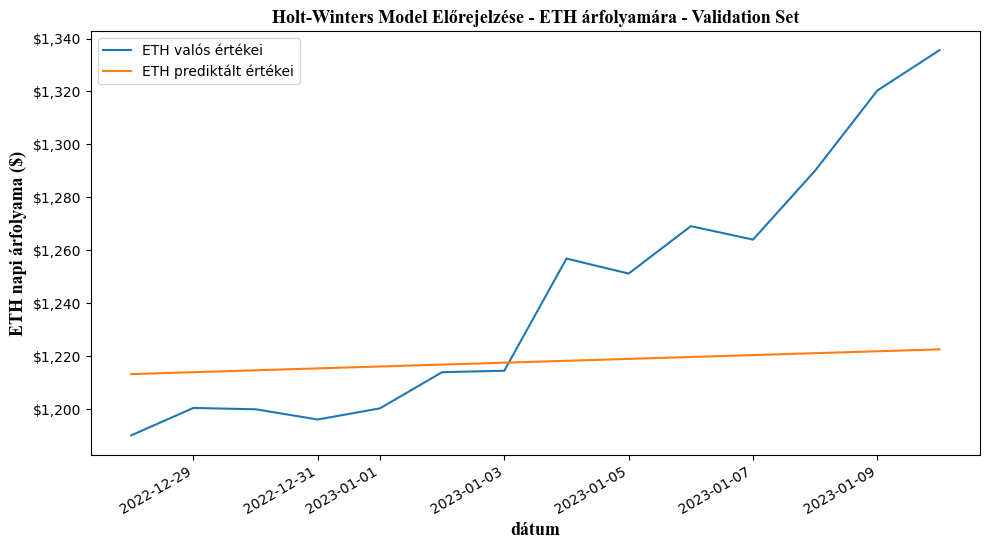

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(test["eth_close"], label="ETH valós értékei")
ax.plot(np.exp(fcast), label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_title("Holt-Winters Model Előrejelzése - ETH árfolyamára - Validation Set", **font)
plt.savefig("charts/forecast/holt-winters_forecast_example.png")
plt.show()

In [47]:
test["eth_close"]

date
2022-12-28    1190.15
2022-12-29    1200.49
2022-12-30    1199.99
2022-12-31    1196.13
2023-01-01    1200.34
2023-01-02    1214.00
2023-01-03    1214.55
2023-01-04    1256.90
2023-01-05    1251.24
2023-01-06    1269.14
2023-01-07    1264.07
2023-01-08    1290.16
2023-01-09    1320.39
2023-01-10    1335.62
Freq: D, Name: eth_close, dtype: float64

In [49]:
np.exp(fcast)

2022-12-28    1213.281265
2022-12-29    1213.997164
2022-12-30    1214.713485
2022-12-31    1215.430229
2023-01-01    1216.147396
2023-01-02    1216.864986
2023-01-03    1217.583000
2023-01-04    1218.301437
2023-01-05    1219.020298
2023-01-06    1219.739583
2023-01-07    1220.459293
2023-01-08    1221.179427
2023-01-09    1221.899987
2023-01-10    1222.620971
Freq: D, dtype: float64

## Findings

- Legjobb RMSE: 100.6174
- Legjobb MSE: 100.6174
- Legjobb MAE: 86.4984
- Legjobb MAPE: 5.5945


Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: None
damped_trend: False
init_method: legacy-heuristic

## Test on Real-World dataset

## 1 day real world prediction

In [65]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [66]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [67]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=0)] ## 1 day

In [68]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [69]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [70]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [71]:
eth_current_price.tail()

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692


In [72]:
train = df_close.copy()

In [73]:
# best
# trend_type: add
# seasonal_type: None
# damped_trend: True
# init_method: legacy-heuristic

In [74]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="legacy-heuristic",
      trend="add",
      damped_trend=True,
      seasonal=None)

In [75]:
res = m.fit()

In [78]:
eth_current_price["logprediction"] = res.forecast(len(eth_current_price))

In [79]:
eth_current_price["prediction"] = np.exp(eth_current_price["logprediction"])

In [81]:
eth_current_price

,eth_close,logclose,logprediction,prediction
Date,,,,
2023-03-08,1534.088257,7.335692,7.35299,1560.857227


In [82]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

26.768969782220665

In [83]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

716.5777432014431

In [84]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

26.768969782220665

In [85]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.01744943269263514

## Findings

1 day forecast
- RMSE: 26.76
- MSE: 716.57
- MAE: 26.76
- MAPE: 1.74

## 3 day real world prediction

In [86]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [87]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [88]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=2)] ## 1 day

In [89]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [90]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [91]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [92]:
eth_current_price.tail()

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841


In [93]:
train = df_close.copy()

In [94]:
# best
# trend_type: add
# seasonal_type: mul
# damped_trend: True
# init_method: legacy-heuristic

In [95]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="legacy-heuristic",
      trend="add",
      damped_trend=True,
      seasonal="mul",
      seasonal_periods=365)

In [96]:
res = m.fit()

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [97]:
eth_current_price["logprediction"] = res.forecast(len(eth_current_price))

In [98]:
eth_current_price["prediction"] = np.exp(eth_current_price["logprediction"])

In [99]:
eth_current_price

,eth_close,logclose,logprediction,prediction
Date,,,,
2023-03-08,1534.088257,7.335692,7.357476,1567.874278
2023-03-09,1438.660767,7.271468,7.362879,1576.368798
2023-03-10,1429.158081,7.264841,7.348467,1553.812078


In [100]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

109.00094217798366

In [101]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

11881.205395688137

In [102]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

98.71601664427226

In [103]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.06832169906838244

## Findings

3 day forecast
- RMSE: 109.00
- MSE: 11881.20
- MAE: 98.71
- MAPE: 6.83

## 7 day real world prediction

In [104]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [105]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [106]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=6)] ## 1 day

In [107]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [108]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [109]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [111]:
eth_current_price

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674
2023-03-13,1680.308960,7.426733
2023-03-14,1703.507080,7.440444


In [112]:
train = df_close.copy()

In [94]:
# best
# trend_type: mul
# seasonal_type: None
# damped_trend: False
# init_method: estimated

In [114]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="estimated",
      trend="mul",
      damped_trend=False,
      seasonal=None)

In [115]:
res = m.fit()

In [116]:
eth_current_price["logprediction"] = res.forecast(len(eth_current_price))

In [117]:
eth_current_price["prediction"] = np.exp(eth_current_price["logprediction"])

In [118]:
eth_current_price

,eth_close,logclose,logprediction,prediction
Date,,,,
2023-03-08,1534.088257,7.335692,7.354475,1563.176519
2023-03-09,1438.660767,7.271468,7.355067,1564.102051
2023-03-10,1429.158081,7.264841,7.355659,1565.028205
2023-03-11,1482.616699,7.301564,7.356251,1565.954983
2023-03-12,1590.292969,7.371674,7.356843,1566.882384
2023-03-13,1680.308960,7.426733,7.357435,1567.810409
2023-03-14,1703.507080,7.440444,7.358027,1568.739058


In [119]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

102.36768614095867

In [120]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

10479.14316585382

In [121]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

92.059301707931

In [122]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.05974554510949492

## Findings

7 day forecast
- RMSE: 102.36
- MSE: 10479.14
- MAE: 92.059
- MAPE: 5.97

## 14 day real world prediction

In [123]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [124]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [125]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=13)] ## 1 day

In [126]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [127]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [128]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [129]:
eth_current_price

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674
2023-03-13,1680.308960,7.426733
2023-03-14,1703.507080,7.440444
2023-03-15,1656.180542,7.412269
2023-03-16,1677.215454,7.424890


In [130]:
train = df_close.copy()

In [131]:
# best
# trend_type: add
# seasonal_type: None
# damped_trend: False
# init_method: legacy-heuristic

In [132]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="legacy-heuristic",
      trend="add",
      damped_trend=False,
      seasonal=None)

In [133]:
res = m.fit()

In [134]:
eth_current_price["logprediction"] = res.forecast(len(eth_current_price))

In [135]:
eth_current_price["prediction"] = np.exp(eth_current_price["logprediction"])

In [136]:
eth_current_price

,eth_close,logclose,logprediction,prediction
Date,,,,
2023-03-08,1534.088257,7.335692,7.354585,1563.347551
2023-03-09,1438.660767,7.271468,7.355279,1564.433969
2023-03-10,1429.158081,7.264841,7.355974,1565.521142
2023-03-11,1482.616699,7.301564,7.356669,1566.609071
2023-03-12,1590.292969,7.371674,7.357363,1567.697755
2023-03-13,1680.308960,7.426733,7.358058,1568.787197
2023-03-14,1703.507080,7.440444,7.358753,1569.877395
2023-03-15,1656.180542,7.412269,7.359447,1570.968351
2023-03-16,1677.215454,7.424890,7.360142,1572.060065


In [137]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

145.57028183712563

In [138]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

21190.70695414019

In [139]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

131.32877907027105

In [140]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.07833252766682645

## Findings

14 day forecast
- RMSE: 145.57
- MSE: 21190.70
- MAE: 131.32
- MAPE: 7.83

## BACKUP

In [ ]:
## Forecast horizon
## Validation steps

h = qr ## ez maga a window size (seasonalitásnál fontos), hogy mekkora lépésközre prediktál, 365 napra előre pl
steps = 10 ## ez nem más, mint az, hogy 10 szer lép egyet előre az indexekben, magyarul ez a cv=10 kb Gridsearchnél
Ntest = len(df_close) - h -steps + 1 ## ez a kiindulási pont, érdemes lehet megnézni a 80%-körüli értéket

In [ ]:
def walkforward(trend_type, seasonal_type, damped_trend, init_method, debug=False):

  # store errors
    errors = []
    seen_last = False
    steps_completed = 0

    for end_of_train in range(Ntest, len(df_close) - h + 1): ## plusz egy a range miatt van.
        train = df_close.iloc[:end_of_train] # one step walk
        test = df_close.iloc[end_of_train:end_of_train + h]

        if test.index[-1] == df.index[-1]:
            seen_last = True
      
        steps_completed += 1

        if seasonal_type != None:
            
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type,
                  seasonal_periods=365)
        else:
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type)
        
        res_hw = hw.fit()

      # compute error for the forecast horizon
        fcast = res_hw.forecast(h)
        error = mean_squared_error(test['logclose'], fcast, squared=False) ## root mean squared error
        errors.append(error)

    if debug:
            print("seen_last:", seen_last)
            print("steps completed:", steps_completed)

    return np.mean(errors)

In [ ]:
test_size = 14
train = df_close.iloc[:-test_size]
test = df_close.iloc[-test_size:]

In [ ]:
train_idx = df_close.index <= train.index[-1] ## csak belőjük a trainingset indexeit
test_idx = df_close.index > train.index[-1]

In [ ]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="legacy-heuristic",
      trend="mul",
      damped_trend=True,
      seasonal="add",
      seasonal_periods=365)

In [ ]:
res = m.fit()

In [ ]:
## Logarithmic prediction
df_close.loc[train_idx, "SESfitted"] = res.fittedvalues
df_close.loc[test_idx, "SESfitted"] = res.forecast(test_size) ##folytatjuk a trained (efelett) részt a predikcióval
df_close[["logclose", "SESfitted"]].plot(figsize=(10, 5))

In [ ]:
df_close["prediction"] = np.exp(df_close["SESfitted"])

In [ ]:
## Root Value prediction
df_close[["eth_close", "prediction"]].plot(figsize=(10, 5))

In [ ]:
## Validation Root Mean Squared Error
mean_squared_error(df_close['eth_close'].iloc[-test_size:], df_close["prediction"].iloc[-test_size:], squared=False)

In [ ]:
mean_absolute_error(df_close['eth_close'].iloc[-test_size:], df_close["prediction"].iloc[-test_size:])